# xtream Ai Assignment

## Data Exploration

#### Libraries Import

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

seed = 1234

dataset_path = os.path.join('datasets', 'diamonds', 'diamonds.csv')

2024-04-01 12:10:49.077730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Loading

In [2]:
diamonds_df = pd.read_csv(dataset_path)

### Preliminary Data Analysis
We analyze the first five rows of the dataset to visualize the data and the data distribution in the dataset.
We can already see that some features have values that do not describe the elements as they're supposed to. 
 - Price has a minimum value of -1 which is not expected.
 - x, y and z have a minimum value of 0 which should not be allowed considering they're expressing a dimension and it cannot be zero.

There are no missing values.

In [3]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [4]:
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


In [5]:
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


In [6]:
diamonds_df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

### Data Cleaning
We removed the records with wrong values. We can see that we've deleted 11 records.

In [7]:
# Remove rows where x, y, and z are zero and price is -1
diamonds_df = diamonds_df[(diamonds_df['x'] != 0) & (diamonds_df['y'] != 0) & (diamonds_df['z'] != 0) & (diamonds_df['price'] != -1)]
diamonds_df.reset_index(drop=True, inplace=True)
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,0.794117,61.710844,57.446242,3930.581880,5.726232,5.728821,3.533678
std,0.467981,1.445563,2.259752,3970.923311,1.116257,1.109167,0.688437
min,0.230000,44.000000,51.600000,351.000000,3.860000,3.840000,1.410000
25%,0.400000,61.000000,56.000000,942.000000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2398.000000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5376.000000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.000000,10.000000,9.850000,6.430000


### Data Visualization
Plot basic graph showing the correlation between numerical features. We can already see that x and y dimensions are highly correlated and they can potentially be synthesized in a single feature.

The graphs show some outliers from the blob of data but we cannot make any assumption on the records since their values describe a feasible representation of a diamond.

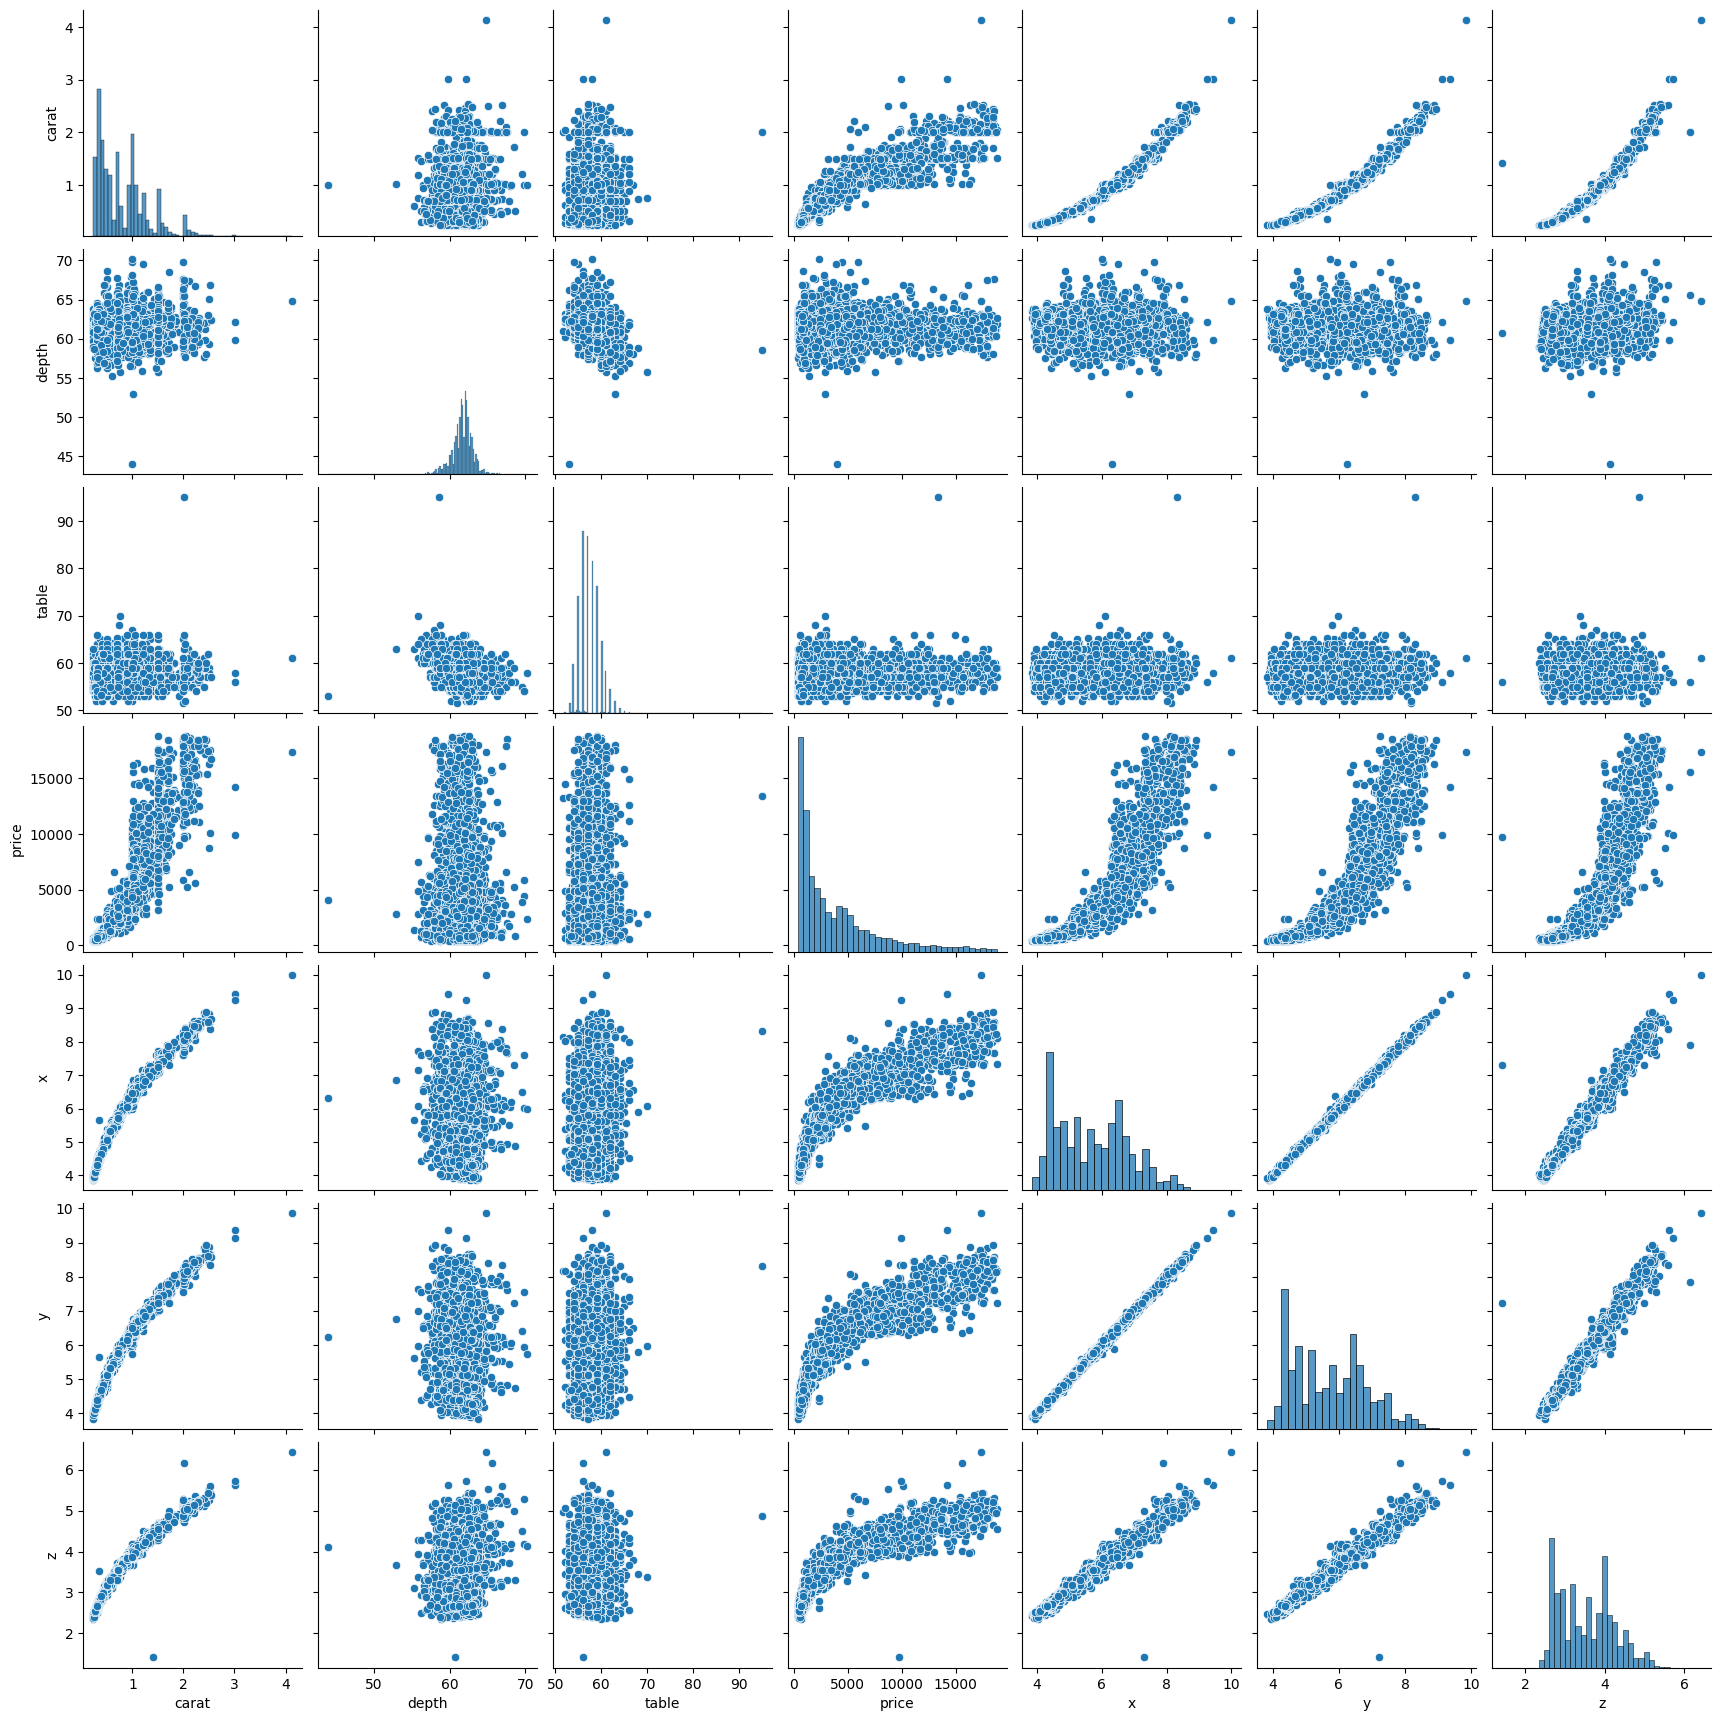

In [8]:
sns.pairplot(diamonds_df, vars=['carat', 'depth', 'table', 'price', 'x', 'y', 'z'])
plt.show()

#### Correlation
From the scatter plots above we can already see that features describing the diamond dimension are higly correlated (carat, x, y ,z). The correlation matrix below confirms it. 

When data is higly correlated there are some consideration to make:
- Multicollinearity: it makes it difficult to understand which feature is driving the prediction of the model.
- Model Performance: the model might not be able to generalize on unseen data.

In the next steps we will perform Principal Component Analysis (PCA).

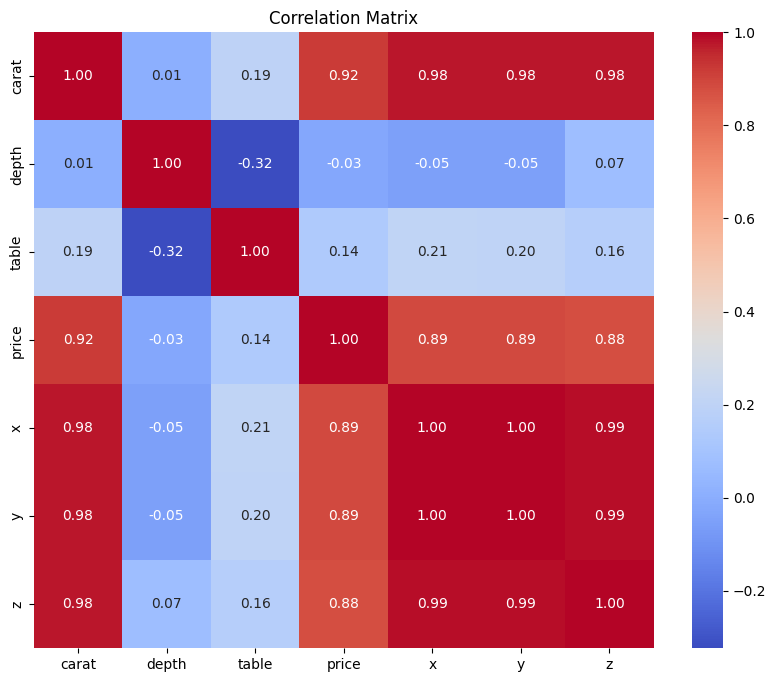

In [9]:
# Select only numerical columns
numerical_columns = diamonds_df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Categorical Variables

Our datasets presents 3 categorical variables: cut, color, and clarity.

Based on the dataset provided description, we can assume that all of these variables have an internal order that describes the quality of the diamond.

In [10]:
print(f'Cut unique values: {diamonds_df['cut'].unique()}')
print(f'Color unique values: {diamonds_df['color'].unique()}')
print(f'Clarity unique values: {diamonds_df['clarity'].unique()}')

Cut unique values: ['Ideal' 'Premium' 'Very Good' 'Good' 'Fair']
Color unique values: ['H' 'I' 'F' 'G' 'E' 'D' 'J']
Clarity unique values: ['SI2' 'SI1' 'VS2' 'IF' 'VVS2' 'VS1' 'I1' 'VVS1']


In [11]:
# Define custom order for cut categories
cut_custom_order = {'Ideal': 1, 'Premium': 2, 'Very Good': 3, 'Good': 4, 'Fair': 5}
# Define custom order for color categories
color_custom_order = {'D': 1, 'E': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6, 'J': 7}
# Define custom order for clarity categories
clarity_custom_order = { 'IF': 1, 'VVS1': 2, 'VVS2': 3, 'VS1': 4, 'VS2': 5, 'SI1': 6, 'SI2': 7, 'I1': 8}

# Create a new column with cut custom order
diamonds_df['cut_custom_order'] = diamonds_df['cut'].map(cut_custom_order)
# Create a new column with color custom order
diamonds_df['color_custom_order'] = diamonds_df['color'].map(color_custom_order)
# Create a new column with clarity custom order
diamonds_df['clarity_custom_order'] = diamonds_df['clarity'].map(clarity_custom_order)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the cut custom order column
diamonds_df['cut_encoded'] = label_encoder.fit_transform(diamonds_df['cut_custom_order'])
# Apply label encoding to the color custom order column
diamonds_df['color_encoded'] = label_encoder.fit_transform(diamonds_df['color_custom_order'])
# Apply label encoding to the clarity custom order column
diamonds_df['clarity_encoded'] = label_encoder.fit_transform(diamonds_df['clarity_custom_order'])

# Drop the intermediate columns
diamonds_df.drop(columns=['cut_custom_order', 'color_custom_order', 'clarity_custom_order'], inplace=True)

# Check the mapping has been succesful
desired_order_column = ['color', 'color_encoded', 'cut', 'cut_encoded', 'clarity', 'clarity_encoded']
diamonds_df[desired_order_column].head()

,color,color_encoded,cut,cut_encoded,clarity,clarity_encoded
0,H,4,Ideal,0,SI2,6
1,H,4,Ideal,0,SI1,5
2,I,5,Premium,1,SI1,5
3,F,2,Ideal,0,SI1,5
4,F,2,Very Good,2,VS2,4


### Categorical Variables visualization

Let's visualize the categorical variables we've just encoded and their correlation with the other variables.

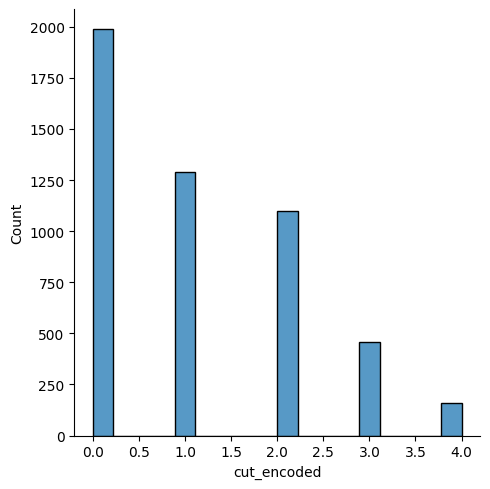

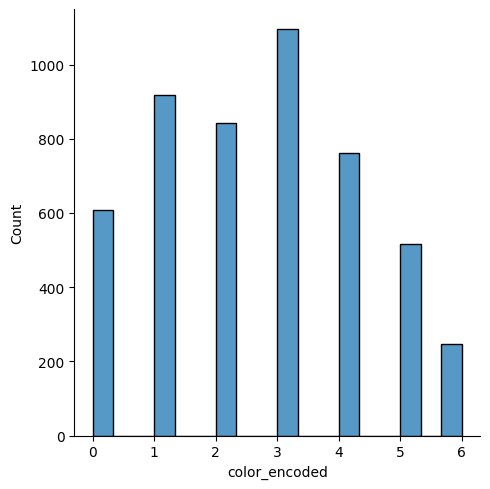

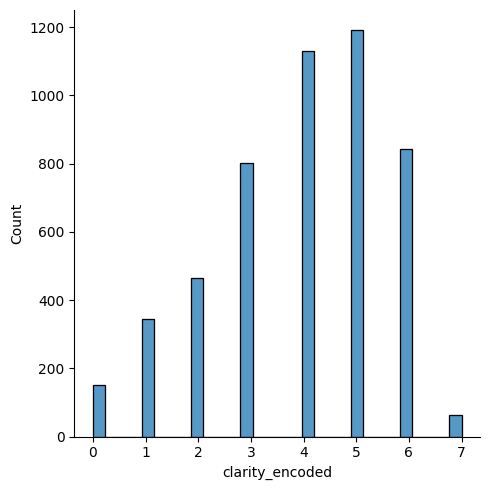

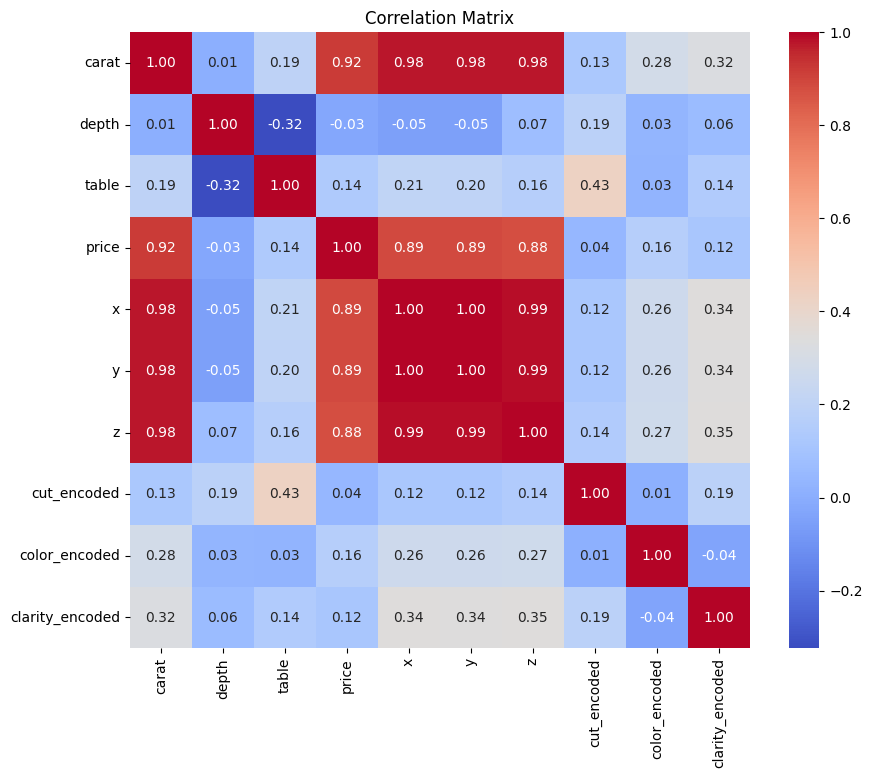

In [12]:
sns.displot(diamonds_df['cut_encoded'])

sns.displot(diamonds_df['color_encoded'])

sns.displot(diamonds_df['clarity_encoded'])
plt.show()

# Select only numerical columns
numerical_columns = diamonds_df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We can see that we have some skewed distributions on cut categories. Based on the previous graph we can also notice that the prices distribution is unbalanced with more samples on the lower price tier. We should take this characteristics of the dataset in consideration when choosing the prediction model and picking one that is able to handle unbalanced data.

The encoded categorical variables don't show any particular correlation with the other variables.

### Dimensionality Reduction: PCA

From the previous graph we can see that carat is quadratically correlated with x, y, and z. We can apply a transformation to make carat linearly correlated to the dimesion variables. 

With further thinking we can see that the carat describes the weight of the diamond so it is more likely that it represent a power of 3 with respect to the dimensions. We will apply a transformation with the cube root.

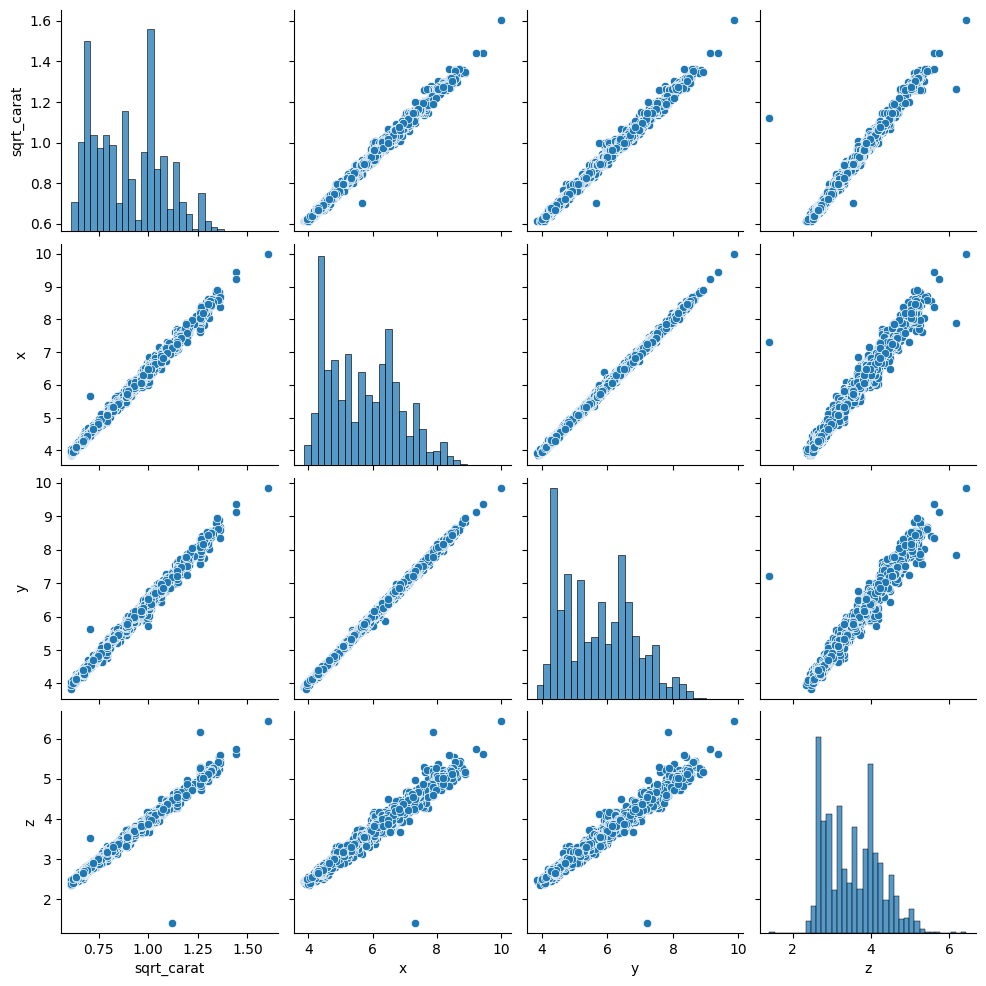

In [24]:
# Apply square root transformation to the variable
diamonds_df['sqrt_carat'] = np.cbrt(diamonds_df['carat'])

# Check that the transformed variable is linearly correlated to the others.
sns.pairplot(diamonds_df, vars=['sqrt_carat', 'x', 'y', 'z'])
plt.show()

We can see that the dimension variables and the square root of the carat are now linearly correlated. Now we can apply PCA.

In [14]:
selected_data = diamonds_df[['sqrt_carat', 'x', 'y', 'z']]

# Initialize PCA with desired number of components
pca = PCA(n_components=1)  # Choose the number of components we want to retain

# Fit PCA to the selected features
pca.fit(selected_data)

# Transform the selected features to their principal components
selected_data_pca = pca.transform(selected_data)

diamonds_df['dimension_pca'] = selected_data_pca

#### Normalization
Let's normalize the values to have zero mean and unitary standard deviation. Handling small numbers generally helps models during training, in particular with neural networks.

In [15]:
feature_cols = ['depth', 'table', 'cut_encoded', 'color_encoded', 'clarity_encoded', 'dimension_pca']
target_col = ['price']
diamonds_df[feature_cols] = (diamonds_df[feature_cols] - diamonds_df[feature_cols].mean()) / diamonds_df[feature_cols].std()

#### Dataset Creation

In [16]:
# https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
train_size = 0.7
val_size = 0.2
test_size = 0.1

train, val, test = np.split(diamonds_df.sample(frac=1, random_state=seed), 
                            [int(train_size * len(diamonds_df)), int((train_size + val_size) * len(diamonds_df))])
print(f'train size: {train.shape[0]}, val size: {val.shape[0]}, test size: {test.shape[0]}')

train size: 3492, val size: 998, test size: 499


/Users/lucianofranchin/miniconda3/envs/xtream_conda_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Gradient Boosting Model

/Users/lucianofranchin/miniconda3/envs/xtream_conda_env/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Mean Squared Error: 415469.53


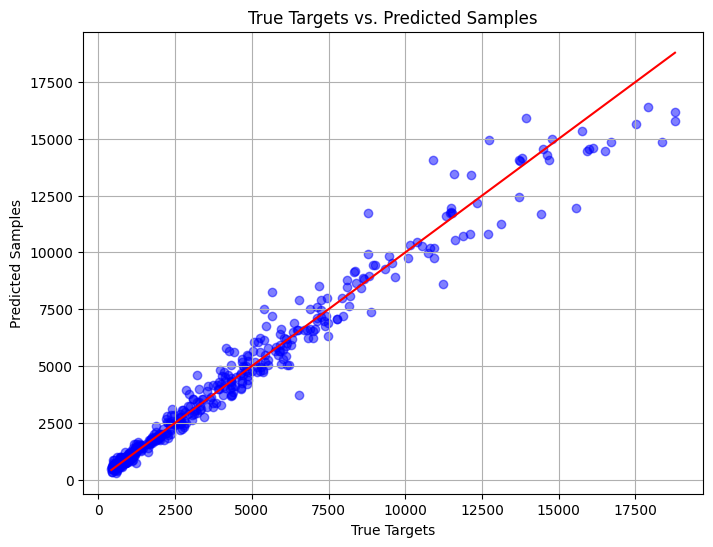

In [17]:
# Merge train and validation, we don't need a validation dataset with this model
gb_train = pd.concat([train, val], ignore_index=True)

# Instantiate the GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)

gb_regressor.fit(gb_train[feature_cols].values, gb_train[target_col].values)

#### Model Evaluation

In [ ]:
y_pred = gb_regressor.predict(test[feature_cols].values)

mse = mean_squared_error(test[target_col].values, y_pred)

print(f'Square Root Mean Squared Error: {np.sqrt(mse):.2f}')

# Plot true targets vs. predicted samples
plt.figure(figsize=(8, 6))
plt.scatter(test[target_col].values, y_pred, color='blue', alpha=0.5)
plt.plot([min(test[target_col].values), max(test[target_col].values)], [min(test[target_col].values), max(test[target_col].values)], color='red')  # Plotting the diagonal line
plt.title('True Targets vs. Predicted Samples')
plt.xlabel('True Targets')
plt.ylabel('Predicted Samples')
plt.grid(True)
plt.show()

### Pytorch Tests: Model Definition
Here we will declare the pytorch model used to perform regression and the functions needed to train it.

In [18]:
# Define the neural network architecture
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x

#### Torch Dataset Preparation and Hyperparameters Declaration

In [19]:
batch_size = 16
patience = 30  # Number of epochs to wait for improvement
hidden_size = 2 ** 12  # Number of units in the hidden layer
num_epochs = 10000

# Dataset definition (input and target variables)
X_train = torch.tensor(train[feature_cols].values, dtype=torch.float32)  # input data
y_train = torch.tensor(train[target_col].values, dtype=torch.float32)  # target variable

X_val = torch.tensor(val[feature_cols].values, dtype=torch.float32)
y_val = torch.tensor(val[target_col].values, dtype=torch.float32)

X_test = torch.tensor(test[feature_cols].values, dtype=torch.float32)
y_test = torch.tensor(test[target_col].values, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### Model Creation

In [20]:
# Create a SummaryWriter object, Tensorboard integration
writer = SummaryWriter()

# Define hyperparameters
input_size = X_train.shape[1]  # Number of features

output_size = 1  # Output size for regression (single value)

# Define your model, loss function, and optimizer
model = RegressionModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize variables for early stopping
best_val_loss = float('inf')

counter = 0  # Counter for epochs without improvement

# Training loop with validation

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # Add square root to read more meaningfull results
        loss = torch.sqrt(criterion(outputs, targets.unsqueeze(1)))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        writer.add_scalar('Loss/train', train_loss, epoch)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets.unsqueeze(1)))
            val_loss += loss.item() * inputs.size(0)

    # Print training and validation loss
    train_loss /= len(train_dataloader.dataset)
    val_loss /= len(val_dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    # Check if early stopping criteria met
    if counter >= patience:
        print("Early stopping: No improvement in validation loss.")
        break

# Close the SummaryWriter when finished
writer.close()

/Users/lucianofranchin/miniconda3/envs/xtream_conda_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/lucianofranchin/miniconda3/envs/xtream_conda_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/lucianofranchin/miniconda3/envs/xtream_conda_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (t

Epoch [1/10000], Train Loss: 3992.3054, Val Loss: 3835.4826
Epoch [2/10000], Train Loss: 3870.5917, Val Loss: 3860.2585
Epoch [3/10000], Train Loss: 3883.0592, Val Loss: 3845.5329
Epoch [4/10000], Train Loss: 3895.7529, Val Loss: 3851.5309
Epoch [5/10000], Train Loss: 3891.7799, Val Loss: 3834.0744
Epoch [6/10000], Train Loss: 3882.2080, Val Loss: 3877.6246
Epoch [7/10000], Train Loss: 3887.0221, Val Loss: 3858.8599
Epoch [8/10000], Train Loss: 3885.2353, Val Loss: 3855.1629
Epoch [9/10000], Train Loss: 3876.9903, Val Loss: 3898.0692
Epoch [10/10000], Train Loss: 3865.4506, Val Loss: 3930.7313
Epoch [11/10000], Train Loss: 3883.4616, Val Loss: 3843.9793
Epoch [12/10000], Train Loss: 3865.0516, Val Loss: 3873.5561
Epoch [13/10000], Train Loss: 3887.7696, Val Loss: 3805.0632
Epoch [14/10000], Train Loss: 3867.6432, Val Loss: 3863.2279
Epoch [15/10000], Train Loss: 3863.7685, Val Loss: 3854.5774
Epoch [16/10000], Train Loss: 3883.8072, Val Loss: 4077.7003
Epoch [17/10000], Train Loss: 388

#### Model Evaluation

/Users/lucianofranchin/miniconda3/envs/xtream_conda_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 3743.4341


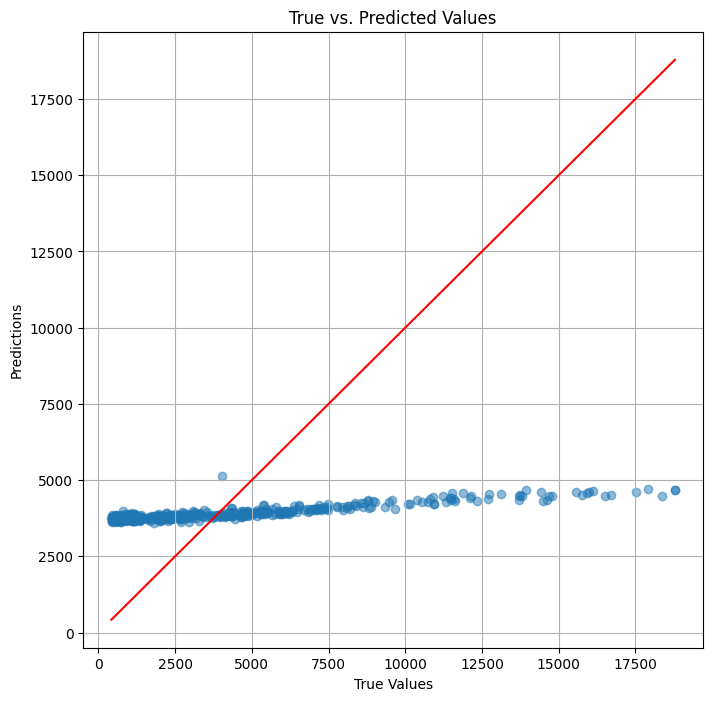

In [21]:
# Evaluate model on test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        loss = torch.sqrt(criterion(outputs, targets.unsqueeze(1)))
        test_loss += loss.item() * inputs.size(0)

# Calculate test loss
test_loss /= len(test_dataloader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Make predictions on test set
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        all_predictions.extend(outputs.squeeze().tolist())
        all_targets.extend(targets.tolist())

# Convert predictions and targets to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Plot predictions vs. targets
plt.figure(figsize=(8, 8))
plt.scatter(all_targets, all_predictions, alpha=0.5)
plt.plot([min(test[target_col].values), max(test[target_col].values)], [min(test[target_col].values), max(test[target_col].values)], color='red')  # Plotting the diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()


From this graph we can see that the model is overfitting on the diamonds with prices between 2500 and 5000. The neural network model does not perform well with unbalanced datasets, since the scope of the analysis is not to find the best model we'll just leave this here for example or further analysis and proceed with the next steps.